# 5th_homework

### Import Section

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.base import BaseEstimator

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from matplotlib import pyplot as plt

### Global Settings Section

In [2]:
random_state_global = 0

## 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [3]:
df_data = pd.read_csv('churn_data.csv')

In [4]:
df_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
df_data['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

##### Наблюдается дисбаланс классов.

### Preprocessing

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_data.drop(columns=['Exited']), df_data['Exited'],
                                                   random_state=random_state_global, stratify=df_data['Exited'])

##### Объявим классы для обработки признаков в pipeline.

In [8]:
class CategoricalFeatureSelector(BaseEstimator):
    def __init__(self, column):
        self.column = column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.column]


class NumericalFeatureSelector(BaseEstimator):
    def __init__(self, column):
        self.column = column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[[self.column]]


class OneHotEncoder(BaseEstimator):
    def __init__(self, key):
        self.key = key
        self.columns = None
    
    def fit(self, X, y=None):
        self.columns = [column for column in pd.get_dummies(X, prefix=self.key).columns]
        return self
    
    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        for column in self.columns:
            if column not in X.columns:
                X[column] = 0
        return X[self.columns]


class FeaturesDeletion(BaseEstimator):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns)

##### Классифицируем признаки: избыточные, непрерывные, категориальные.

In [9]:
list_features_deletion = ['RowNumber', 'CustomerId', 'Surname']
list_features_numerical = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']
list_features_categorical = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']

##### Реализуем pipeline для предобработки признаков.

In [10]:
list_pipelines_numerical_scaled = []

for feature in list_features_numerical:
    pipeline_new = Pipeline([
        (f'selector_{feature}', NumericalFeatureSelector(column=feature)),
        (f'scaler_{feature}', StandardScaler())
    ])
    list_pipelines_numerical_scaled.append((feature, pipeline_new))


list_pipelines_numerical = []

for feature in list_features_numerical:
    pipeline_new = Pipeline([
        (f'selector_{feature}', NumericalFeatureSelector(column=feature))
    ])
    list_pipelines_numerical.append((feature, pipeline_new))


list_pipelines_categorical = []

for feature in list_features_categorical:
    pipeline_new = Pipeline([
        (f'selector_{feature}', CategoricalFeatureSelector(column=feature)),
        (f'ohe_{feature}', OneHotEncoder(key=feature))
    ])
    list_pipelines_categorical.append((feature, pipeline_new))

### LogisticRegression

In [11]:
pipeline_model_lr = Pipeline([
    ('features_deletion_', FeaturesDeletion(columns=list_features_deletion)),
    ('features_preprocessing', FeatureUnion(list_pipelines_numerical_scaled + list_pipelines_categorical, n_jobs=-1)),
    ('classifier', LogisticRegression(random_state=random_state_global))
])

##### Используем кросс-валидацию для перебора и поиска лучших параметров.

In [12]:
%%time

dict_params = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__class_weight': [None, {1: 0.8, 0: 0.2}, {1: 0.7, 0: 0.3}, {1: 0.6, 0: 0.4}],
    'classifier__solver': ['lbfgs', 'saga']
}

grid_search_lr = GridSearchCV(estimator=pipeline_model_lr,
                              param_grid=dict_params,
                              scoring='f1',
                              n_jobs=-1,
                              cv=3)

grid_search_lr.fit(X_train, y_train)

Wall time: 1.9 s


c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
36 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\sergeyz06\appdata\local\programs\python\python39\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\users\sergeyz06\appdata\local\programs\python\pyt

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features_deletion_',
                                        FeaturesDeletion(columns=['RowNumber',
                                                                  'CustomerId',
                                                                  'Surname'])),
                                       ('features_preprocessing',
                                        FeatureUnion(n_jobs=-1,
                                                     transformer_list=[('CreditScore',
                                                                        Pipeline(steps=[('selector_CreditScore',
                                                                                         NumericalFeatureSelector(column='CreditScore')),
                                                                                        ('scaler_CreditScore',
                                                                                         StandardScal

In [13]:
grid_search_lr.best_params_, grid_search_lr.best_score_

({'classifier__class_weight': {1: 0.8, 0: 0.2},
  'classifier__penalty': 'none',
  'classifier__solver': 'lbfgs'},
 0.49315647962801085)

##### Постоим модель с использованием лучших параметров.

In [14]:
dict_params = grid_search_lr.best_params_
dict_params = dict(zip([x.split('__')[1] for x in list(dict_params.keys())], dict_params.values()))

dict_params

{'class_weight': {1: 0.8, 0: 0.2}, 'penalty': 'none', 'solver': 'lbfgs'}

In [15]:
pipeline_model_lr = Pipeline([
    ('features_deletion_', FeaturesDeletion(columns=list_features_deletion)),
    ('features_preprocessing', FeatureUnion(list_pipelines_numerical_scaled + list_pipelines_categorical, n_jobs=-1)),
    ('classifier', LogisticRegression(random_state=random_state_global, **dict_params))
])

In [16]:
%%time

pipeline_model_lr.fit(X_train, y_train)

Wall time: 48.6 ms


Pipeline(steps=[('features_deletion_',
                 FeaturesDeletion(columns=['RowNumber', 'CustomerId',
                                           'Surname'])),
                ('features_preprocessing',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('CreditScore',
                                                 Pipeline(steps=[('selector_CreditScore',
                                                                  NumericalFeatureSelector(column='CreditScore')),
                                                                 ('scaler_CreditScore',
                                                                  StandardScaler())])),
                                                ('Age',
                                                 Pipeline(steps=[('selector_A...
                                                                  CategoricalFeatureSelector(column='HasCrCard')),
                                                     

In [17]:
%%time

y_preds = pipeline_model_lr.predict_proba(X_test)[:, 1]
y_pred = pipeline_model_lr.predict(X_test)

Wall time: 32.9 ms


In [18]:
y_preds[:5], y_pred[:5]

(array([0.26731647, 0.61436423, 0.13586509, 0.47909198, 0.50200159]),
 array([0, 1, 0, 0, 1], dtype=int64))

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1991
           1       0.38      0.73      0.50       509

    accuracy                           0.70      2500
   macro avg       0.65      0.71      0.65      2500
weighted avg       0.80      0.70      0.73      2500



In [20]:
list_precision, list_recall, list_threshold = precision_recall_curve(y_test, y_preds)

list_f1_score = 2 * (list_precision * list_recall) / (list_precision + list_recall)
index_best = np.argmax(list_f1_score)

df_metrics = pd.DataFrame(data={
    'Threshold': list_threshold[index_best],
    'Precision': list_precision[index_best],
    'Recall': list_recall[index_best],
    'F1-score': list_f1_score[index_best]
}, index=['LogisticRegression'])

df_metrics

,Threshold,Precision,Recall,F1-score
LogisticRegression,0.545164,0.410539,0.658153,0.50566


### GradientBoostingClassifier

In [21]:
pipeline_model_gbc = Pipeline([
    ('feature_deletion', FeaturesDeletion(columns=list_features_deletion)),
    ('features_preprocessing', FeatureUnion(list_pipelines_numerical + list_pipelines_categorical, n_jobs=-1)),
    ('classifier', GradientBoostingClassifier(random_state=random_state_global))
])

##### Используем кросс-валидацию для перебора и поиска лучших параметров.

In [22]:
%%time

dict_params = {
    'classifier__min_samples_split': [100],
    'classifier__min_samples_leaf': [5, 10, 15],
    'classifier__max_depth': [5, 10, 15]
}

grid_search_gbc = GridSearchCV(estimator=pipeline_model_gbc,
                               param_grid=dict_params,
                               scoring='f1',
                               n_jobs=-1,
                               cv=3)

grid_search_gbc.fit(X_train, y_train)

Wall time: 7.24 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feature_deletion',
                                        FeaturesDeletion(columns=['RowNumber',
                                                                  'CustomerId',
                                                                  'Surname'])),
                                       ('features_preprocessing',
                                        FeatureUnion(n_jobs=-1,
                                                     transformer_list=[('CreditScore',
                                                                        Pipeline(steps=[('selector_CreditScore',
                                                                                         NumericalFeatureSelector(column='CreditScore'))])),
                                                                       ('Age',
                                                                        Pipeline(steps=[('selector_Age',
                           

In [23]:
grid_search_gbc.best_params_, grid_search_gbc.best_score_

({'classifier__max_depth': 5,
  'classifier__min_samples_leaf': 10,
  'classifier__min_samples_split': 100},
 0.6055859903072155)

##### Постоим модель с использованием лучших параметров.

In [24]:
dict_params = grid_search_gbc.best_params_
dict_params = dict(zip([x.split('__')[1] for x in list(dict_params.keys())], dict_params.values()))

dict_params

{'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 100}

In [25]:
pipeline_model_gbc = Pipeline([
    ('feature_deletion', FeaturesDeletion(columns=list_features_deletion)),
    ('features_preprocessing', FeatureUnion(list_pipelines_numerical + list_pipelines_categorical, n_jobs=-1)),
    ('classifier', GradientBoostingClassifier(random_state=random_state_global, **dict_params))
])

In [26]:
%%time

pipeline_model_gbc.fit(X_train, y_train)

Wall time: 1.2 s


Pipeline(steps=[('feature_deletion',
                 FeaturesDeletion(columns=['RowNumber', 'CustomerId',
                                           'Surname'])),
                ('features_preprocessing',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('CreditScore',
                                                 Pipeline(steps=[('selector_CreditScore',
                                                                  NumericalFeatureSelector(column='CreditScore'))])),
                                                ('Age',
                                                 Pipeline(steps=[('selector_Age',
                                                                  NumericalFeatureSelector(column='Age')...
                                                                  CategoricalFeatureSelector(column='HasCrCard')),
                                                                 ('ohe_HasCrCard',
                                    

In [27]:
%%time

y_preds = pipeline_model_gbc.predict_proba(X_test)[:, 1]
y_pred = pipeline_model_gbc.predict(X_test)

Wall time: 70.8 ms


In [28]:
y_preds[:5], y_pred[:5]

(array([0.01704077, 0.07250419, 0.02251402, 0.0506439 , 0.3504711 ]),
 array([0, 0, 0, 0, 0], dtype=int64))

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1991
           1       0.72      0.46      0.56       509

    accuracy                           0.85      2500
   macro avg       0.80      0.71      0.74      2500
weighted avg       0.84      0.85      0.84      2500



In [30]:
list_precision, list_recall, list_threshold = precision_recall_curve(y_test, y_preds)

list_f1_score = 2 * (list_precision * list_recall) / (list_precision + list_recall)
index_best = np.argmax(list_f1_score)

df_metrics.loc['GradientBoostingClassifier', :] = [
    list_threshold[index_best],
    list_precision[index_best],
    list_recall[index_best],
    list_f1_score[index_best]
]

df_metrics

,Threshold,Precision,Recall,F1-score
LogisticRegression,0.545164,0.410539,0.658153,0.505660
GradientBoostingClassifier,0.275359,0.590991,0.644401,0.616541


## 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

##### Приоритет метрик данной задачи может меняться в зависимости от поставленных целей.
##### В случае наличия достаточных средств на удержание клиентов необходимо максимизировать метрику "Recall". Данный подход позволит выявить максимальное количество клиентов, склонных к оттоку. Пострадает метрика "Precision" из-за чего часть средств будет потрачена на клиентов ложно классифицированных как склонных к оттоку. Однако в целом потеря клиентов будет минимизирована.
##### Если средства на удержание клиентов ограничены, то необходимо максимизировать метрику "Precision", при неком фиксированном значении метрики "Recall". Это позволит с большей вероятностью выявить клиентов действительно склонных к оттоку, однако будет охвачена меньшая доля таких клиентов. Таким образом, средства на удержание клиентов будут потрачены именно на склонных к оттоку клиентов.

##### Модель "GradientBoostingClassifier" демонстрирует значительно лучшие метрики качества "Precision" и "F1-score" и лишь немного уступает в качестве метрики "Recall" моделе "LogisticRegression". Таким образом, модель "GradientBoostingClassifier" более предпочтительна, так в целом более точна.

## 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

##### Используя лучший порог получим метки классов для каждого объекта.

In [31]:
y_pred_best = np.where(y_preds <= df_metrics.loc['GradientBoostingClassifier', 'Threshold'], 0, 1)
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1991
           1       0.59      0.64      0.62       509

    accuracy                           0.84      2500
   macro avg       0.75      0.76      0.76      2500
weighted avg       0.84      0.84      0.84      2500



##### Используя метки построим матрицу заблуждений.

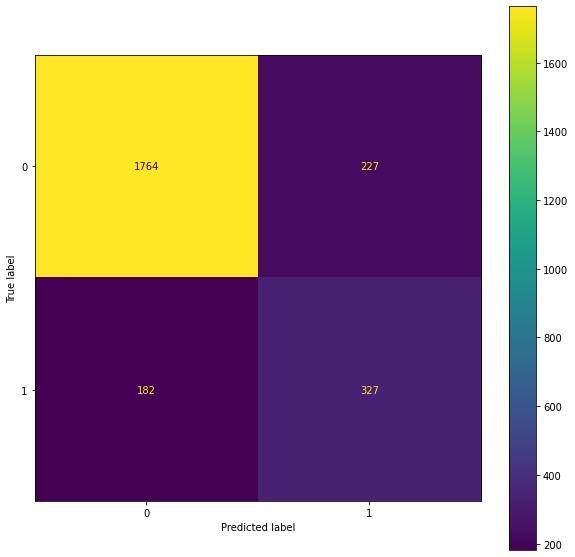

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))

cm = confusion_matrix(y_test, y_pred_best)
cmd = ConfusionMatrixDisplay(cm)

cmd.plot(ax=ax)

##### Модель классифировала 554 клиента (TP + FP = 327 + 227 = 554), как склонных к оттоку. На удержание данных клиентов было потрачено: 554 * 1\\$ = 554\\$.
##### В дейсвительности только 327 клиентов (TP = 327) были склонны к оттоку, которых удалось удержать. Данные клиенты принесли прибыль: 327 * 2\\$ = 654\\$.
##### Выгода от применения модели составила: 654\\$ - 554\\$ = 100\\$.
##### При этом ушло 182 клиента (FN = 182), что привело к упущенной выгоде: 182 * 2\\$ = 364\\$.

## 4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

##### Подбор гиперпараметров был изначально реализован.

## 5. (опционально) Еще раз провести оценку экономической эффективности

##### Теперь проведём оценку экономической эффективности лучшей модели без настройки лучших гиперпараметров.

In [33]:
pipeline_model_gbc = Pipeline([
    ('feature_deletion', FeaturesDeletion(columns=list_features_deletion)),
    ('features_preprocessing', FeatureUnion(list_pipelines_numerical + list_pipelines_categorical, n_jobs=-1)),
    ('classifier', GradientBoostingClassifier(random_state=random_state_global))
])

In [34]:
%%time

pipeline_model_gbc.fit(X_train, y_train)

Wall time: 737 ms


Pipeline(steps=[('feature_deletion',
                 FeaturesDeletion(columns=['RowNumber', 'CustomerId',
                                           'Surname'])),
                ('features_preprocessing',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('CreditScore',
                                                 Pipeline(steps=[('selector_CreditScore',
                                                                  NumericalFeatureSelector(column='CreditScore'))])),
                                                ('Age',
                                                 Pipeline(steps=[('selector_Age',
                                                                  NumericalFeatureSelector(column='Age')...
                                                 Pipeline(steps=[('selector_HasCrCard',
                                                                  CategoricalFeatureSelector(column='HasCrCard')),
                               

In [35]:
%%time

y_preds = pipeline_model_gbc.predict_proba(X_test)[:, 1]

Wall time: 34.9 ms


In [36]:
list_precision, list_recall, list_threshold = precision_recall_curve(y_test, y_preds)

list_f1_score = 2 * (list_precision * list_recall) / (list_precision + list_recall)
index_best = np.argmax(list_f1_score)

df_metrics.loc['GradientBoostingClassifier_base', :] = [
    list_threshold[index_best],
    list_precision[index_best],
    list_recall[index_best],
    list_f1_score[index_best]
]

df_metrics

,Threshold,Precision,Recall,F1-score
LogisticRegression,0.545164,0.410539,0.658153,0.505660
GradientBoostingClassifier,0.275359,0.590991,0.644401,0.616541
GradientBoostingClassifier_base,0.326575,0.650215,0.595285,0.621538


In [37]:
y_pred_best = np.where(y_preds <= df_metrics.loc['GradientBoostingClassifier_base', 'Threshold'], 0, 1)
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1991
           1       0.65      0.59      0.62       509

    accuracy                           0.85      2500
   macro avg       0.77      0.76      0.76      2500
weighted avg       0.85      0.85      0.85      2500



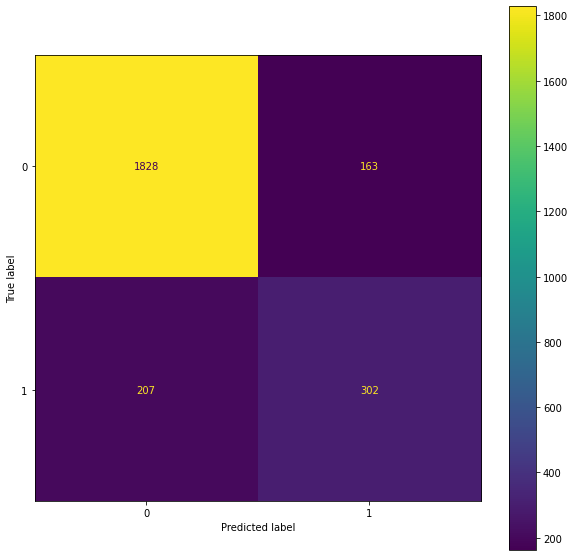

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

cm = confusion_matrix(y_test, y_pred_best)
cmd = ConfusionMatrixDisplay(cm)

cmd.plot(ax=ax)

##### Модель классифировала 465 клиентов (TP + FP = 302 + 163 = 465), как склонных к оттоку. На удержание данных клиентов было потрачено: 465 * 1\\$ = 465\\$.
##### В дейсвительности только 302 клиента (TP = 302) были склонны к оттоку, которых удалось удержать. Данные клиенты принесли прибыль: 302 * 2\\$ = 604\\$.
##### Выгода от применения модели составила: 604\\$ - 465\\$ = 139\\$.
##### При этом ушло 207 клиентов (FN = 207), что привело к упущенной выгоде: 207 * 2\\$ = 414\\$.

### Сравнение моделей

##### Настроенная модель принесла 100\\$ чистой прибыли и 364\\$ упущенной прибыли.
##### Базовая модель принесла 139\\$ чистой прибыли и 414\\$ упущенной прибыли.
##### Таким образом, настроенная модель принесла на 39\\$ меньше чистой прибыли, но при этом смогла уменьшить упущенную прибыль на 50\\$, что даёт суммарный выйгрыш от её применения в 11\\$ в сравнении с базовой моделью.